In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
class EMA: 
    
    def __init__(self, symbol):
        
        self.symbol = symbol
        self.data = None 
        self.tc = 0.001
        
    def prepare_data(self, freq, EMA_S, EMA_L): 
        ''' Prepares the Data for Backtesting.
        '''
        freq = f"{freq}min"
        data_resampled = self.data.resample(freq).last().dropna().iloc[:-1].copy()
        data_resampled["returns"] = np.log(1 + data_resampled.Close.pct_change())
        data_resampled.dropna()
        ######### INSERT THE STRATEGY SPECIFIC CODE HERE ##################

        ema_s = data_resampled["Close"].ewm(span=EMA_S, min_periods=EMA_S).mean()
        ema_l = data_resampled["Close"].ewm(span=EMA_L, min_periods=EMA_L).mean()

        position = np.zeros(len(data_resampled))
        position[ema_s > ema_l] = 1
        ###################################################################
        position = pd.Series(position, index=data_resampled.index).ffill().fillna(0)
        data_resampled = data_resampled.assign(position=position)
        self.results = data_resampled
        
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        trades = self.results["position"].diff().abs().shift(1)
        strategy = self.results["position"].shift(1) * self.results["returns"]
        strategy_net = strategy - trades * self.tc
        self.results = self.results.assign(strategy=strategy,
                                           trades=trades,
                                           strategy_net=strategy_net)
        
        
    def test_strategy(self, freq=5, sma_s=None, sma_l=None):  # Adj!!!
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).

        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)

        window: int
            time window (number of bars) to calculate the simple moving average price (SMA).

        dev: int
            number of standard deviations to calculate upper and lower bands.
        '''
        self.prepare_data(freq, sma_s, sma_l)
        #self.upsample()
        self.run_backtest()

# Evaluate EMA

In [4]:
ticker = "XRPUSDT"
path = os.path.join("../../../hist_data", ticker, f"{ticker}.parquet.gzip")
df = pd.read_parquet(path)

In [8]:
#ema.results["position"].diff().abs().shift(1).value_counts()

In [6]:
ema = EMA(symbol = ticker)
ema.data = df.copy()
ema.prepare_data(260, 25,60)
ema.run_backtest()

In [9]:
ema.results.position.value_counts()

0.0    5333
1.0    3804
Name: position, dtype: int64

In [10]:
ema.results.trades.value_counts()

0.0    9003
1.0     132
Name: trades, dtype: int64

# Evaluate Results

In [14]:
len(ema.results)

9137

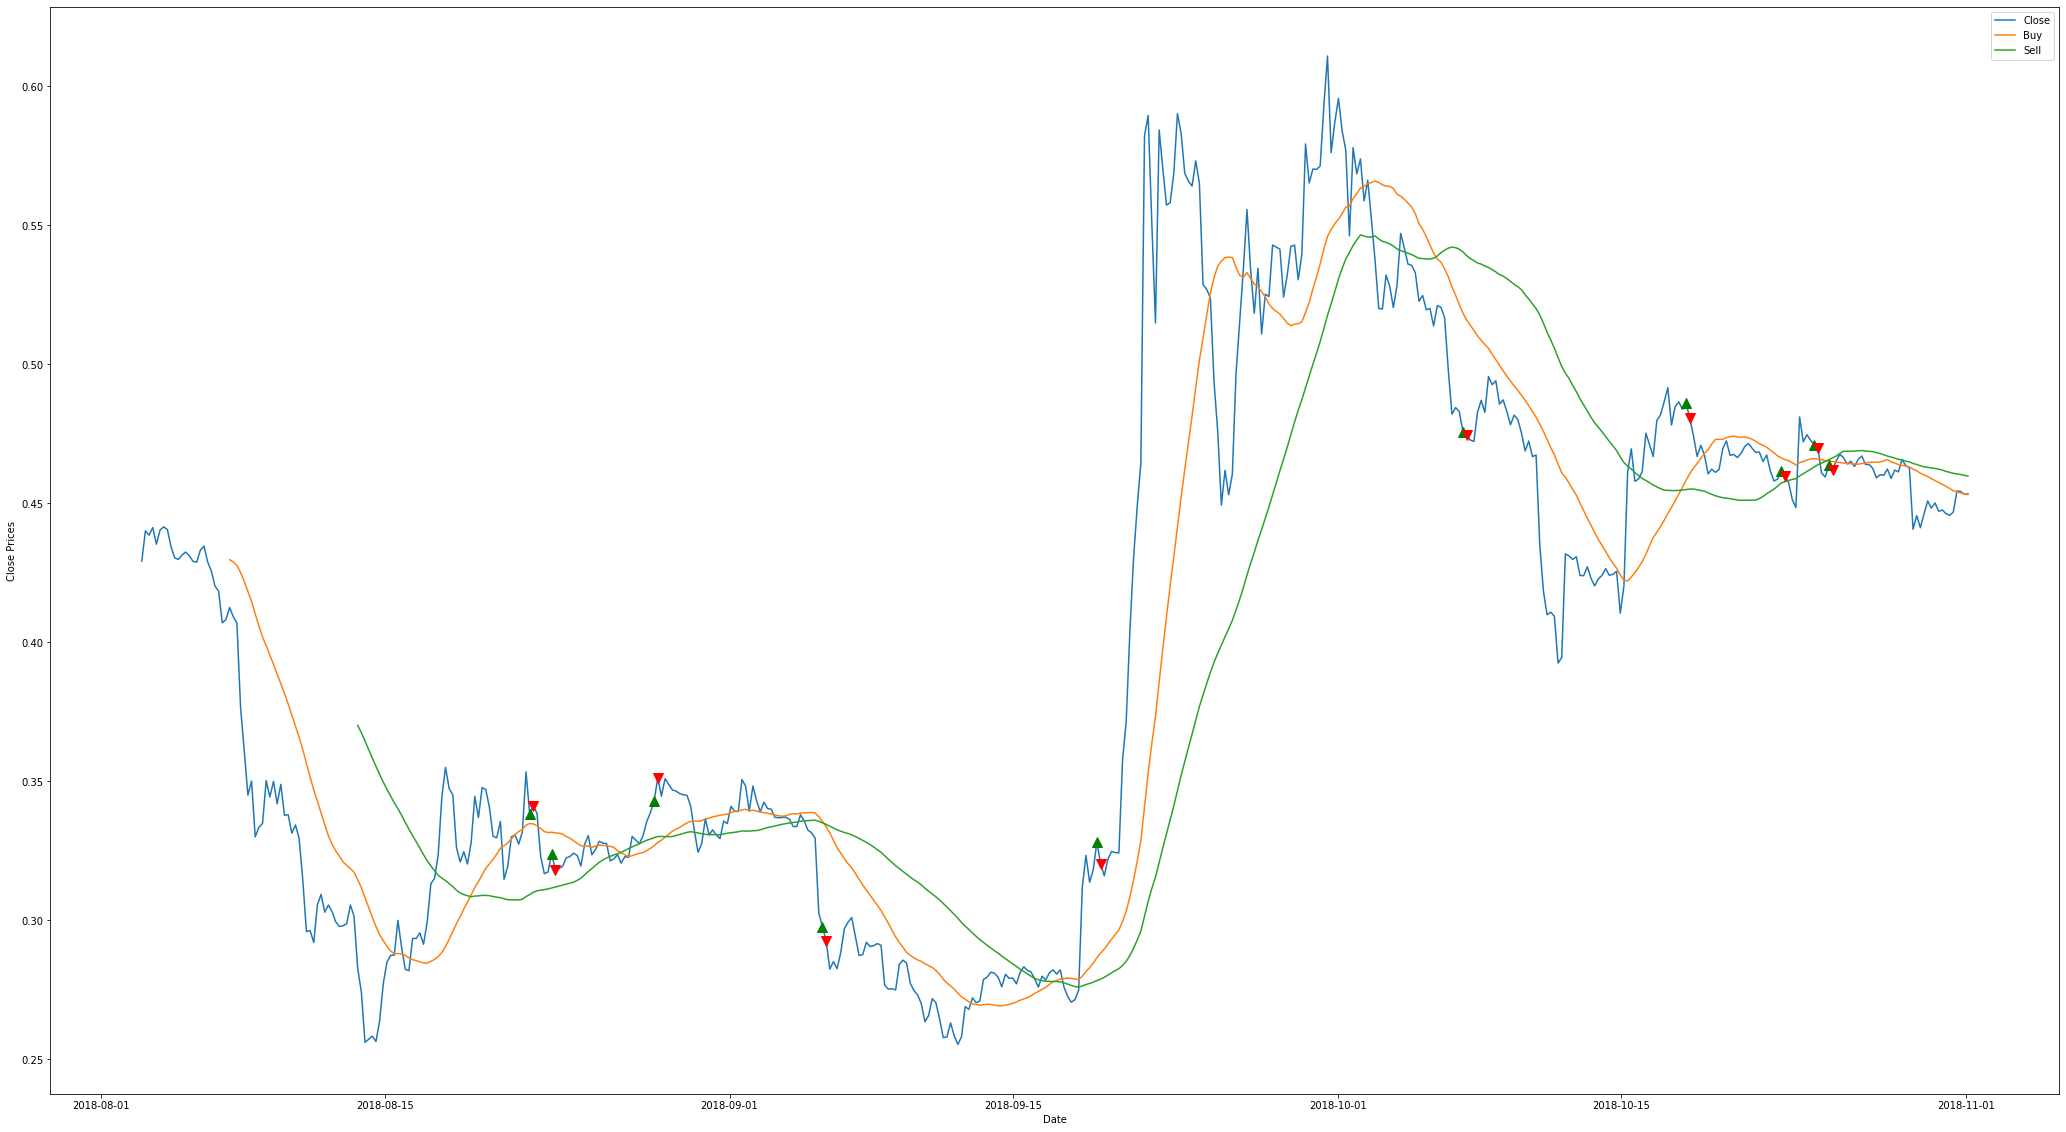

In [23]:
import matplotlib.pyplot as plt

# Plot the Close prices

results = ema.results.iloc[1:1000, :]
#results = ema.results.copy()
plt.figure(figsize=(36, 20))
plt.plot(results.index, results["Close"])
plt.plot(results.index, results["Close"].rolling(25).mean())
plt.plot(results.index, results["Close"].rolling(60).mean())
# Initialize previous signal variable
prev_signal = 0

# Add arrows for buy (1) and sell (0) signals
for i in range(len(results)):
    if results["trades"][i] == 1 and prev_signal != 1:
        plt.plot(results.index[i], results["Close"][i], "^g", markersize=10)
        prev_signal = 1
    elif results["trades"][i] == 0 and prev_signal != 0:
        plt.plot(results.index[i], results["Close"][i], "vr", markersize=10)
        prev_signal = 0

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Prices")
plt.legend(["Close", "Buy", "Sell"])

# Show the plot
plt.show()

# Evaluate Optimizing Results

In [52]:
path = "./XRPUSDT/XRPUSDT_EMA.csv"
res = pd.read_csv(path)

In [53]:
res.sort_values(by="outperf_net", ascending=False)

,freq,EMA_S,EMA_L,num_trades,strat_multiple,bh_multiple,outperf_net,outperf,num_samples
102,90.0,10.0,50.0,714.0,7.549,0.367,3.329,7.182,26359.0
161,135.0,15.0,70.0,334.0,5.024,0.371,3.226,4.653,17580.0
99,85.0,15.0,50.0,590.0,6.246,0.369,3.093,5.877,27916.0
73,65.0,10.0,60.0,890.0,7.825,0.364,2.849,7.461,36497.0
90,80.0,10.0,50.0,794.0,6.944,0.367,2.772,6.577,29657.0
...,...,...,...,...,...,...,...,...,...
9,10.0,15.0,50.0,6028.0,1.193,0.361,-0.358,0.832,237081.0
10,10.0,15.0,60.0,5510.0,0.554,0.361,-0.359,0.193,237081.0
7,10.0,10.0,60.0,6778.0,1.017,0.361,-0.360,0.656,237081.0
8,10.0,10.0,70.0,6278.0,0.423,0.361,-0.360,0.062,237081.0


In [ ]:
res